# Tutorial 02


## Missing Data

Many datasets contain missing values. This can be due to various reasons, such as a faulty manual data entry process, equipment errors or incorrect measurements. Missing data is one of the most challenging problem in data preprocessing.

Ways how to treat them:
* **Deletion** - removing of rows/features with missing data (listwise deletion).
* **Imputation** - process of replacing missing data with substituted values.

The deletion is useful when only a few records contain missing data. 

Otherwise, we may to perform data imputation methods. Unfortunately, the best imputation method does not exist. By using similar arguments as in the ["no free lunch" theorem](https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization), one can see that designing a flawless imputation method is impossible in general.


### Data Imputation

While handling missing data, it is important to know why they are missing and how missing data look like (zda jsou to NaNy, pomlcky,...). 

Missing data mechanisms can determine if any imputation method can help reconstruct a complete dataset.

#### Missing Data Mechanisms
* **MCAR - missing completely at random** - if the probability that the feature is missing is independent of the value of the feature and the values of any other features. In other words, the missing values are independent of the data. This is the best case situation. 

* **MAR - missing at random** -  if the probability that a feature is missing is independent of the value of the feature. In this case, the probability of being missing can depend on the value of the other features. (napr. odeslu napul vyplneny dotaznik - omylem)

* **MNAR (NMAR) - missing not at random** - if the probability that a feature is missing can depend on the value of the feature.

#### Import

In [1]:
import numpy as np
import pandas as pd
import sklearn as skit
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency

import seaborn as sns
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Data load & preprocess

In [2]:
df = pd.read_csv('data.csv')
df['NameLen'] = df.Name.str.len()
df['Sex'] = df['Sex'].str.lower()

# Preparation for title, firstname, and surname extraction from the name
# https://docs.python.org/2/library/re.html
import re
pattern = re.compile('\A\s*([^,]+),\s*([^\.]+\.)\s*([^\(]*)\s*(\(\s*([^\)]*)\s*\))?(.*)\Z') 

def split_name(name):
    if type(name) is not str:
        return np.nan, np.nan, np.nan
    else:
        m = pattern.match(name)
        if m:
            res = m.groups()
            return res[1].strip(), res[0].strip(), res[2].strip()
        else:
            return np.nan, np.nan, np.nan
        
df['Title'], df['Surname'], df['Firstnames'] = zip(*df.Name.apply(split_name))
sex_category = pd.api.types.CategoricalDtype(categories=["male","female"], ordered=False)
df['Sex'] = df['Sex'].astype(sex_category)
pclass_category = pd.api.types.CategoricalDtype(categories=[1,2,3], ordered=True)
df['Pclass'] = df['Pclass'].astype(pclass_category)

### Detection of missing values and their proper representation

NaNs can be used as a poor-man’s mask (if you don’t care what the original value was).
Often one uses [np.nan](https://docs.scipy.org/doc/numpy-1.13.0/user/misc.html).

#### Task - convert ?? in Name to np.nan and update NameLen feature
From the last tutorial we know about one missing data in Name feature.

In [3]:
df[df['Name'] == '??']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameLen,Title,Surname,Firstnames
711,712,0,1,??,male,NaN,0,0,113028,26.55,C124,S,2,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     891 non-null    object  
 12  NameLen      891 non-null    int64   
 13  Title        890 non-null    object  
 14  Surname      890 non-null    object  
 15  Firstnames   890 non-null    object  
dtypes: category(2), float64(2), int64(5), object(7)
memory usage: 99.5+ KB


In [5]:
print(df['Name'].isnull().sum())
print(df['Age'].isnull().sum())

0
177


In [6]:
# Convert ?? for Name to numpy NaN
# Your code here
df['Name'].replace(['??'], np.nan, inplace=True)
df['NameLen'] = df.Name.str.len()

In [7]:
df[df.Name.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameLen,Title,Surname,Firstnames
711,712,0,1,NaN,male,NaN,0,0,113028,26.55,C124,S,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Sex', ylabel='NameLen'>

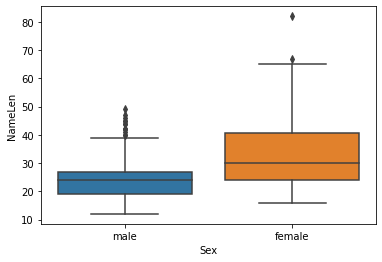

In [8]:
# boxplot does not show NaNs
sns.boxplot(x='Sex', y='NameLen', data=df)

In [9]:
# Counts of nan values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             1
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
NameLen          1
Title            1
Surname          1
Firstnames       1
dtype: int64

### Rows with too many missings or columns with majority of missings

#### Task - drop rows and columns with too many missings
I.e. drop row with missing Name and Cabin column.

In [10]:
# Your code here
# Drop the row with many missings (missing name)
df[df['Name'].isnull() == True].index
print(len(df))
df.dropna(subset=['Name'], inplace=True)
print(len(df))

891
890


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  890 non-null    int64   
 1   Survived     890 non-null    int64   
 2   Pclass       890 non-null    category
 3   Name         890 non-null    object  
 4   Sex          890 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        890 non-null    int64   
 7   Parch        890 non-null    int64   
 8   Ticket       890 non-null    object  
 9   Fare         890 non-null    float64 
 10  Cabin        203 non-null    object  
 11  Embarked     890 non-null    object  
 12  NameLen      890 non-null    float64 
 13  Title        890 non-null    object  
 14  Surname      890 non-null    object  
 15  Firstnames   890 non-null    object  
dtypes: category(2), float64(3), int64(4), object(7)
memory usage: 106.2+ KB


In [12]:
# Your code here
# drop columns with too many nans
# dropnu sloupec cabin
df.drop(columns=['Cabin'], inplace=True)

In [13]:
# Counts of nan values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            176
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
NameLen          0
Title            0
Surname          0
Firstnames       0
dtype: int64

#### Age missings

Too important to drop the feature and too many missings (176) to drop the cases (rows).
We will try to impute reasonable values.

#### Task - impute missing Age based on Title by median
Let's try to implement age imputation based on relations between age and title.
One of the easiest methods is imputation by mean or median. 

<AxesSubplot:xlabel='Title', ylabel='Age'>

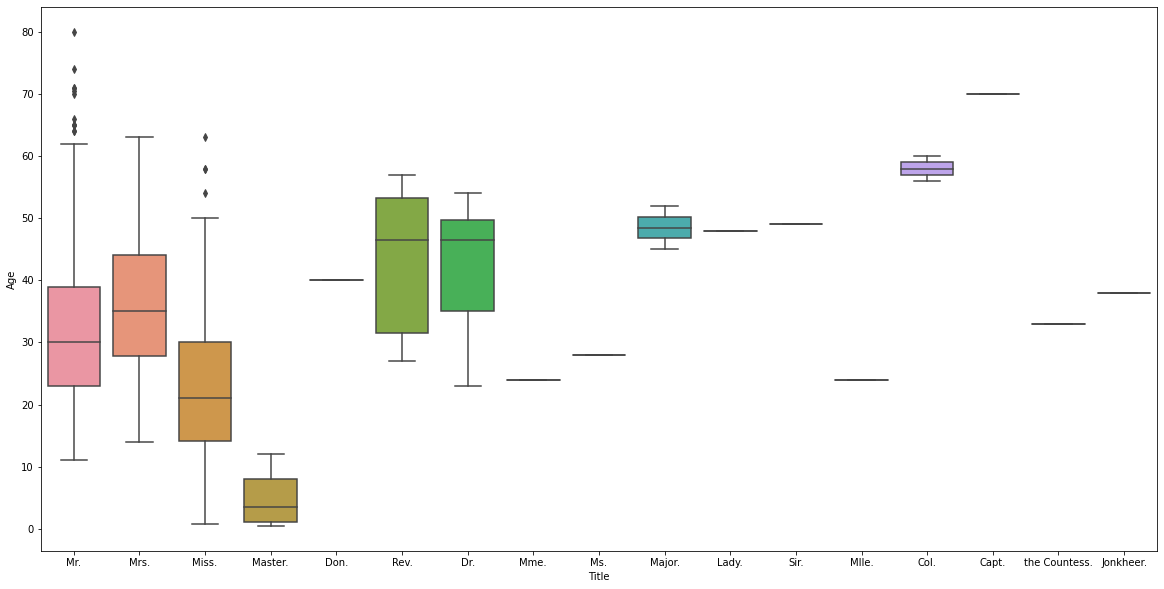

In [14]:
# some exploration
plt.figure(figsize=(20, 10))
sns.boxplot(x='Title', y='Age', data=df)

In [15]:
# Median of Ages per different Titles
df.groupby('Title').Age.median()

Title
Capt.            70.0
Col.             58.0
Don.             40.0
Dr.              46.5
Jonkheer.        38.0
Lady.            48.0
Major.           48.5
Master.           3.5
Miss.            21.0
Mlle.            24.0
Mme.             24.0
Mr.              30.0
Mrs.             35.0
Ms.              28.0
Rev.             46.5
Sir.             49.0
the Countess.    33.0
Name: Age, dtype: float64

In [16]:
# Fill missing Age values by Title median values and put it into new column called "MedianAge"
# if the Age is presented, just create copy of it

# Your code here
df['MedianAge'] = df['Age']
df.loc[df['Age'].isnull(), 'MedianAge'] = df[df['Age'].isnull()].Title.apply(lambda x: df.groupby('Title').Age.median()[x])

# tell me the top 3 passenger's ID with imputed MedianAge
df[df.Age.isnull()].head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameLen,Title,Surname,Firstnames,MedianAge
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q,16.0,Mr.,Moran,James,30.0
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S,28.0,Mr.,Williams,Charles Eugene,30.0
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C,23.0,Mrs.,Masselmani,Fatima,35.0


<AxesSubplot:ylabel='Frequency'>

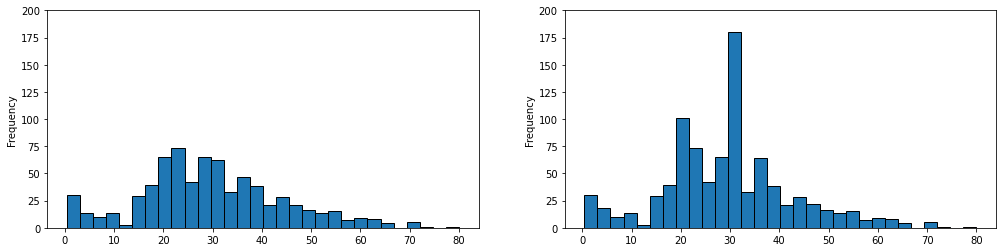

In [17]:
plt.figure(figsize=(17, 4))
plt.subplot(1,2,1)
df.Age.plot.hist(bins=30, edgecolor="black", ylim=(0,200))
plt.subplot(1,2,2)
df.MedianAge.plot.hist(bins=30, edgecolor="black", ylim=(0,200))

### $k$-Nearest Neighbours Imputation

More sophisticated method. However, it is suitable only for low-dimensional datasets, because of the curse of dimensionality. It says that higher the dimension the nearest neighbours get further and further.

Let's use scikit [NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html) and store the newly imputed age into KNNAge feature.

In [18]:
# choose columns to compute nearest neighbors
NNcolumns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title']

# get data into number representations
data = df.loc[:, NNcolumns].copy()

data.select_dtypes(['category']).columns

Index(['Pclass', 'Sex'], dtype='object')

In [19]:
# transform categories to indicators
for column in data.select_dtypes(['category']).columns:
     data[column] = data[column].cat.codes # return Series of codes as well as the index

In [20]:
display(df.head())
display(data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameLen,Title,Surname,Firstnames,MedianAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,23.0,Mr.,Braund,Owen Harris,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,51.0,Mrs.,Cumings,John Bradley,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,22.0,Miss.,Heikkinen,Laina,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,44.0,Mrs.,Futrelle,Jacques Heath,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,24.0,Mr.,Allen,William Henry,35.0


,Pclass,Sex,SibSp,Parch,Title
0,2,0,1,0,Mr.
1,0,1,1,0,Mrs.
2,2,1,0,0,Miss.
3,0,1,1,0,Mrs.
4,2,0,0,0,Mr.


In [21]:
# Pclass encoding example
pclass = df.loc[:, 'Pclass'].copy()
pclass.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [22]:
# one-hot encoding
pclass_onehot = pd.get_dummies(pclass)
pclass_onehot.head()

,1,2,3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [23]:
# dummy encoding created "manually"
pclass_dummies = pd.get_dummies(pclass, drop_first=True)
pclass_dummies.head()

,2,3
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1


In [24]:
# one-hot encoding of strings
data = pd.get_dummies(data)
data.head()

,Pclass,Sex,SibSp,Parch,Title_Capt.,Title_Col.,Title_Don.,Title_Dr.,Title_Jonkheer.,Title_Lady.,...,Title_Master.,Title_Miss.,Title_Mlle.,Title_Mme.,Title_Mr.,Title_Mrs.,Title_Ms.,Title_Rev.,Title_Sir.,Title_the Countess.
0,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
from sklearn.neighbors import NearestNeighbors

# X - points where we know the Age
X = data[~df.Age.isnull()].values
# their indices
Xidx = data[~df.Age.isnull()].index

# Y - points where the Age should be imputed
Y = data[df.Age.isnull()].values
Yidx = data[df.Age.isnull()].index

# training with 5 neighbours
neighbors = NearestNeighbors(5)
neighbors.fit(X)

# get 5 neighbors for each point
Yn = neighbors.kneighbors(Y, return_distance=False)
print(Yn.shape)

# Prepare a new variable
df['KNNAge'] = df.Age

# Impute with mean of 5 nearest neighbours
for i in range(Yn.shape[0]):
    ages = [df.Age[Xidx[idx]] for idx in Yn[i,:]]
    df.loc[Yidx[i], 'KNNAge'] = np.mean(ages)

(176, 5)


C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [26]:
# See some results 
# Note that there are still missing values in Age
# Yidx are indices of missing Age cases

df.loc[Yidx[0:7],:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameLen,Title,Surname,Firstnames,MedianAge,KNNAge
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q,16.0,Mr.,Moran,James,30.0,29.5
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S,28.0,Mr.,Williams,Charles Eugene,30.0,26.0
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C,23.0,Mrs.,Masselmani,Fatima,35.0,45.0
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C,23.0,Mr.,Emir,Farred Chehab,30.0,29.5
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q,29.0,Miss.,O'Dwyer,"Ellen ""Nellie""",21.0,20.0
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,S,19.0,Mr.,Todoroff,Lalio,30.0,29.5
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,C,46.0,Mrs.,Spencer,William Augustus,35.0,41.2


<AxesSubplot:ylabel='Frequency'>

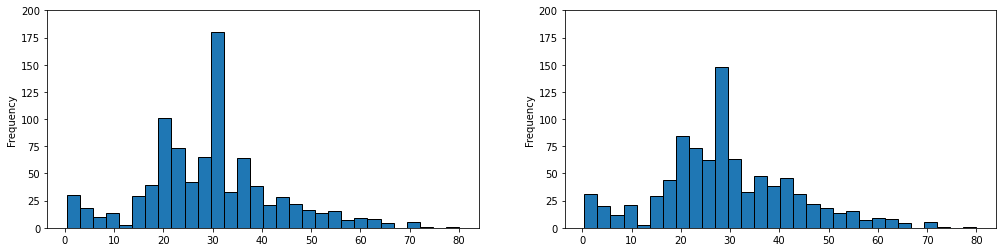

In [27]:
plt.figure(figsize=(17, 4))
plt.subplot(1,2,1)
df.MedianAge.plot.hist(bins=30, edgecolor="black", ylim=(0,200))
plt.subplot(1,2,2)
df.KNNAge.plot.hist(bins=30, edgecolor="black", ylim=(0,200))

In [28]:
# Correlation between previous median imputation based on Titles and this KNN based imputation
df[df.Age.isnull()][['MedianAge', 'KNNAge']].corr()

,MedianAge,KNNAge
MedianAge,1.000000,0.713008
KNNAge,0.713008,1.000000


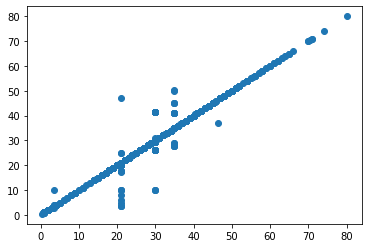

In [29]:
plt.scatter(df.MedianAge, df.KNNAge)

In [30]:
df.loc[Xidx[0:7],:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameLen,Title,Surname,Firstnames,MedianAge,KNNAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,23.0,Mr.,Braund,Owen Harris,22.0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,51.0,Mrs.,Cumings,John Bradley,38.0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,22.0,Miss.,Heikkinen,Laina,26.0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,44.0,Mrs.,Futrelle,Jacques Heath,35.0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,24.0,Mr.,Allen,William Henry,35.0,35.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,23.0,Mr.,McCarthy,Timothy J,54.0,54.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,30.0,Master.,Palsson,Gosta Leonard,2.0,2.0


#### Proper evaluation of the imputation by KNNAge 

In [31]:
# proper evaluation using test data and KNN imputation on entire feature

# new copy of df including Age
NNcolumns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title','Age']
new_data = df.loc[:, NNcolumns].copy()
# transform categories to indicators
for column in new_data.select_dtypes(['category']).columns:
     new_data[column] = new_data[column].cat.codes
# encoding        
new_data = pd.get_dummies(new_data)

In [32]:
# split data on train and test
from sklearn.model_selection import train_test_split
# delete rows containing Age missing values
new_data.drop(new_data.loc[new_data['Age'].isnull()].index, inplace=True)
# split data, no shuffling
X, Y = train_test_split(new_data, test_size=0.3, shuffle=False)

In [33]:
XAge = pd.DataFrame(data = X.Age, columns = ['Age'])
Xidx = X.Age.index
X = X.drop('Age', 1)
# display(XAge.head())
# display(X.head())
YAge = pd.DataFrame(data = Y.Age, columns = ['Age'])
Yidx = YAge.index
Y = Y.drop('Age', 1)
# display(YAge.head())
# display(Y.head())

In [34]:
# training with 5 neighbours
neighbors = NearestNeighbors(5)
neighbors.fit(X)

C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


NearestNeighbors()

In [35]:
# get 5 neighbours for each point
Yn = neighbors.kneighbors(Y, return_distance=False)
print(Yn.shape)
print(Yn)

(215, 5)
[[150 100 285 381  50]
 [320 254   5 498  24]
 [299  94  21 118 349]
 ...
 [142 175  10  46 156]
 [498  74  20   5  63]
 [150 100 285 381  50]]


In [36]:
# Prepare a new dataframe
testAge = pd.DataFrame(columns = ['KNNAge'])

# Impute with mean of 5 nearest neighbours
for i in range(Yn.shape[0]):
    ages = [XAge.Age[Xidx[idx]] for idx in Yn[i,:]]
    testAge.loc[Yidx[i], 'KNNAge'] = np.mean(ages)

testAge['KNNAge'] = testAge['KNNAge'].astype(float)
testAge.head()

,KNNAge
631,25.8
632,50.2
634,8.6
635,26.4
636,25.8


<AxesSubplot:ylabel='Frequency'>

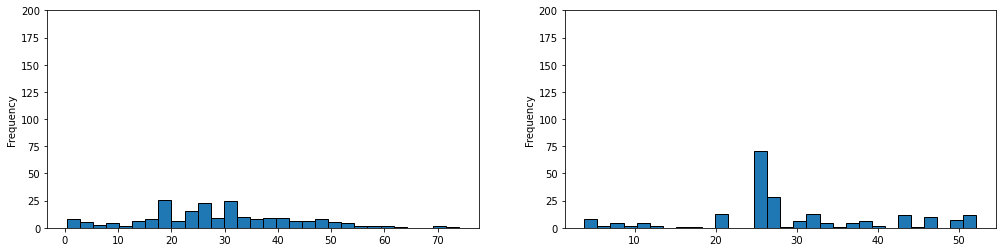

In [37]:
plt.figure(figsize=(17, 4))
plt.subplot(1,2,1)
YAge.Age.plot.hist(bins=30, edgecolor="black", ylim=(0,200))
plt.subplot(1,2,2)
testAge.KNNAge.plot.hist(bins=30, edgecolor="black", ylim=(0,200))

In [38]:
# create df just for computation of corr and scatter plot
result = pd.concat([YAge, testAge], axis=1, join='inner')
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 631 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     215 non-null    float64
 1   KNNAge  215 non-null    float64
dtypes: float64(2)
memory usage: 5.0 KB


In [39]:
result[['Age', 'KNNAge']].corr()

,Age,KNNAge
Age,1.000000,0.570894
KNNAge,0.570894,1.000000


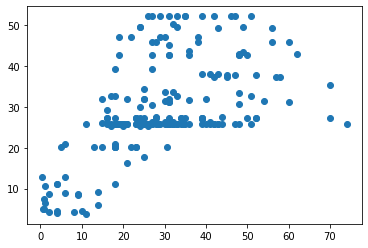

In [40]:
plt.scatter(result.Age, result.KNNAge)

In [41]:
# RMSE evaluation
rmse = ((result.KNNAge - result.Age) ** 2).mean() ** .5
print('RMSE: ', rmse)

RMSE:  12.263119691854278


### Note
For more missing features one may use [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) from scikit-learn. 

It can be used in the scenario of multiple imputation which is known as MICE (Multiple Imputation by Chained Equations). It is now one of the most successfull imputation model.

## Outliers Detection

**single feature** - rule of thumb - Outliers outside of interval (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR) where:
    * Q1 - first quartile
    * Q3 - third quartile
    * IQR - Inter Quartile Range = Q3 - Q1 (middle 50%)
    
    This rule works well for data with Gaussian like distribution.
**multiple feature** - clustering based approaches & distance, density based approaches & model approaches etc.

In [42]:
df.Age = df.KNNAge
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  890 non-null    int64   
 1   Survived     890 non-null    int64   
 2   Pclass       890 non-null    category
 3   Name         890 non-null    object  
 4   Sex          890 non-null    category
 5   Age          890 non-null    float64 
 6   SibSp        890 non-null    int64   
 7   Parch        890 non-null    int64   
 8   Ticket       890 non-null    object  
 9   Fare         890 non-null    float64 
 10  Embarked     890 non-null    object  
 11  NameLen      890 non-null    float64 
 12  Title        890 non-null    object  
 13  Surname      890 non-null    object  
 14  Firstnames   890 non-null    object  
 15  MedianAge    890 non-null    float64 
 16  KNNAge       890 non-null    float64 
dtypes: category(2), float64(5), int64(4), object(6)
memory usage: 153.2+ KB


<AxesSubplot:>

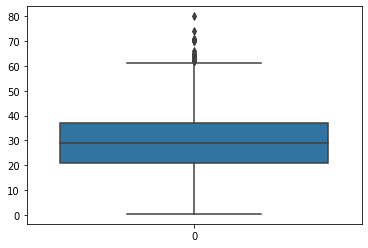

In [43]:
# Single feature
sns.boxplot(data=df.Age)

In [44]:
# Compute IQR for all numeric lengths
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR =  Q3 - Q1

# Find outliers of Age
AgeOut = (df['Age'] > Q3['Age'] + 1.5*IQR['Age']) | (df['Age'] < Q1['Age'] - 1.5*IQR['Age'])
display(AgeOut.sum())
df[AgeOut].sort_values(['Age'], ascending = False).head()

19

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameLen,Title,Surname,Firstnames,MedianAge,KNNAge
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,S,36.0,Mr.,Barkworth,Algernon Henry Wilson,80.0,80.0
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,S,19.0,Mr.,Svensson,Johan,74.0,74.0
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,C,23.0,Mr.,Artagaveytia,Ramon,71.0,71.0
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,C,25.0,Mr.,Goldschmidt,George B,71.0,71.0
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,Q,20.0,Mr.,Connors,Patrick,70.5,70.5


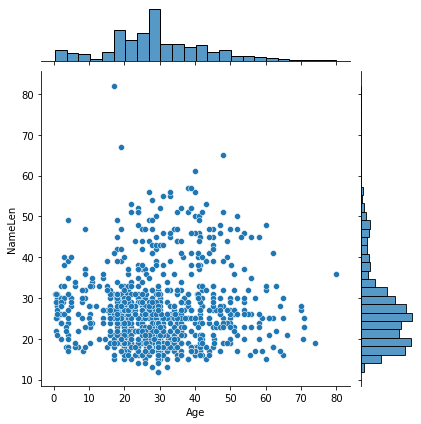

In [45]:
# multiple features
# analyze Age and NameLen together
sns.jointplot(x='Age', y='NameLen', data = df)

#### Task - use $k$-means to find outliers
For multiple features, we shall use $k$-means clustering method to remove outliers. First, find clusters in the data, then observe the distance from the cluster centers. Based on this distance, we remove points which are 'too far'.

Use [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from sklearn.

To set the number of clusters $k$ you can use the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) or more sophisticated cluster evaluation using [Silhoutte analysis/coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering)), or see the [scikit example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

The $k$-means can be seen as standard method followed by modifications as [$k$-means++ - David, Vassilvitskii (2007)](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf), an algorithm for choosing the initial values for $k$-means, or [$k$-medoids](https://en.wikipedia.org/wiki/K-medoids) as another clustering algorithm.

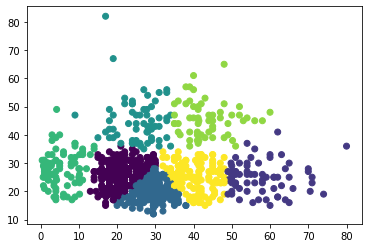

In [46]:
# k-means clustering based on Age and NameLen
data = df[['Age', 'NameLen']]

# You code goes here
# also plot the result as scatter plot

kmeans = KMeans(n_clusters=7, random_state=0).fit(data)

plt.scatter(x=data.Age, y=data.NameLen, c=kmeans.labels_)

In [47]:
# find distances from cluster centroids
# and tell me the distances of the first point

# Your code here

distances = kmeans.transform(data)
# the distances of the first point
distances[1,:]

array([30.00842852, 32.44984148, 32.49779144, 13.79989228, 39.84914611,
        7.6530116 , 26.25280074])

In [48]:
# Distances from nearest cluster centroid
min_distances = pd.Series(np.apply_along_axis(min, 1, distances))

# See 3 largest outliers
print(min_distances.nlargest(3).index)

# find 3 points with largest distance
df.loc[data.iloc[min_distances.nlargest(3).index].index]

Int64Index([307, 630, 427], dtype='int64')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameLen,Title,Surname,Firstnames,MedianAge,KNNAge
307,308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1,0,PC 17758,108.9,C,82.0,Mrs.,Penasco y Castellana,Victor de Satode,17.0,17.0
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,S,36.0,Mr.,Barkworth,Algernon Henry Wilson,80.0,80.0
427,428,1,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0,S,67.0,Miss.,Phillips,Kate Florence,19.0,19.0


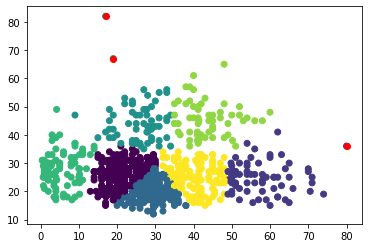

In [49]:
plt.scatter(x=data.Age, y=data.NameLen, c=kmeans.labels_)
indices = data.iloc[min_distances.nlargest(3).index].index
plt.scatter(x=data.Age[indices], y=data.NameLen[indices], c='r')

### Local outlier factor
[LOF](https://en.wikipedia.org/wiki/Local_outlier_factor) measures the local deviation of a data point with respect to its $k$-nearest neighbours. A point is labeled as anomalous if its LOF is larger than 1.

Use [LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) from sklearn.neighbors and try to find some outliers with respect to Age and NameLen.
Note that in scikit you have to check the set up - the negative LOF is used, i.e. the lower, the more abnormal. 

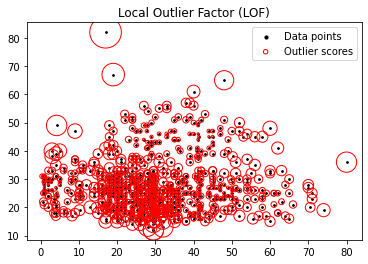

In [50]:
from sklearn.neighbors import LocalOutlierFactor

X = np.array(df[['Age', 'NameLen']])

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')


legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [51]:
# print 4 largest LOF score (negative LOF is used in X_scores)
indices = X_scores.argsort()[0:4]
X_scores[indices]
df.iloc[indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameLen,Title,Surname,Firstnames,MedianAge,KNNAge
307,308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1,0,PC 17758,108.9000,C,82.0,Mrs.,Penasco y Castellana,Victor de Satode,17.0,17.0
427,428,1,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0000,S,67.0,Miss.,Phillips,Kate Florence,19.0,19.0
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,4.2,1,1,2661,15.2458,C,49.0,Master.,Moubarek,Halim Gonios,3.5,4.2
692,693,1,3,"Lam, Mr. Ali",male,29.5,0,0,1601,56.4958,S,12.0,Mr.,Lam,Ali,30.0,29.5
